# Context Pruning

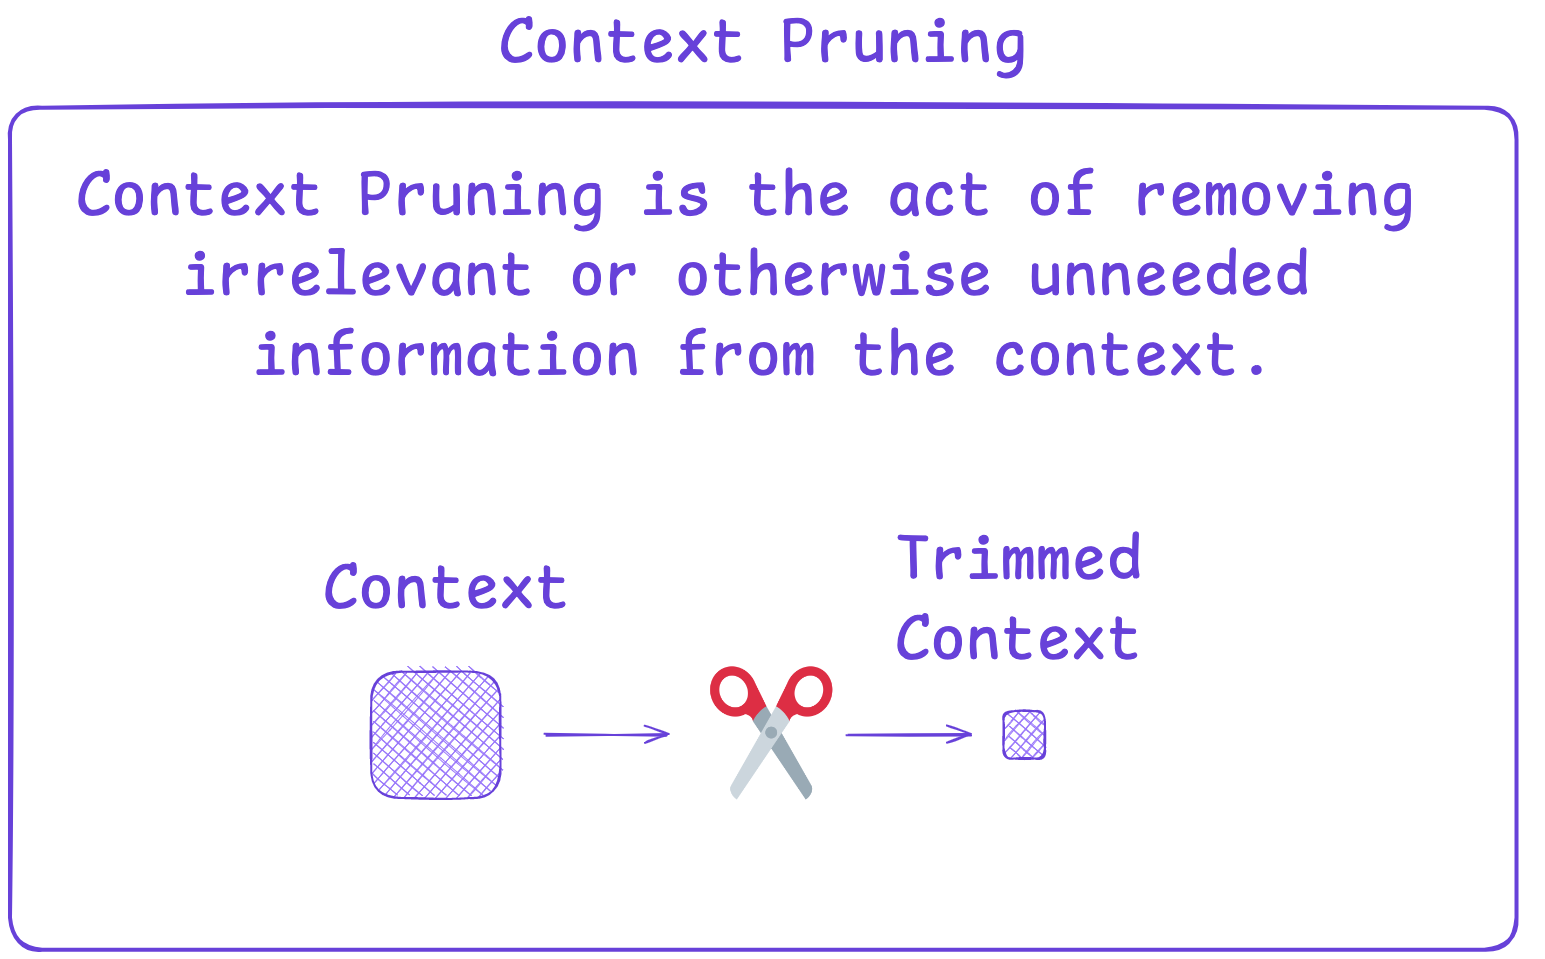

## What is it

*Context Pruning is the act of removing irrelevant or otherwise unneeded information from the context.*

## Why it helps

* Avoids [Context Distraction](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html): When a context grows, the model can over-focuses on the context, neglecting what it learned during training. Chroma's report on [context rot](https://research.trychroma.com/context-rot) shows that LLM performance degrades in surprising and model‑specific ways as the total input length grows. 

## Context Pruning in Practice

As one example, Drew highlights the [Provence tool](https://arxiv.org/abs/2501.16214), which is a trained pruning tool for RAG. It takes a question and context, and strips the context of tokens that are not relevant to the question. However, Cognition warns [that compression can be risky](https://cognition.ai/blog/dont-build-multi-agents) and may introduce new failure points if important details get lost.

## Context Pruning in LangGraph

In LangGraph, it's easy to define and incorporate context pruning into your agents. We'll create a simple pruning step that uses an LLM in the same way as the [Provence tool](https://arxiv.org/abs/2501.16214), prompting it to strip out tokens that are not relevant to the user's request.

In [3]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2025-05-01-thinking/",
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=3000, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [5]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.embeddings import init_embeddings

embeddings = init_embeddings("openai:text-embedding-3-small")
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=embeddings
)
retriever = vectorstore.as_retriever()

In [6]:
from langchain.tools.retriever import create_retriever_tool
from rich.console import Console
from rich.pretty import pprint

# Initialize console for rich formatting
console = Console()

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

result = retriever_tool.invoke({"query": "types of reward hacking"})
console.print("[bold green]Retriever Tool Results:[/bold green]")
pprint(result)

Retriever Tool Results:

'Reward Hacking in Reinforcement Learning | Lil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      Reward Hacking in Reinforcement Learning\n    \nDate: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nBackground\n\nReward Function in RL\n\nSpurious Correlation\n\n\nLet’s Define Reward Hacking\n\nList of Examples\n\nReward hacking examples in RL tasks\n\nReward hacking examples in LLM tasks\n\nReward hacking examples in real life\n\n\nWhy does Reward Hacking Exist?\n\n\nHacking RL Environment\n\nHacking RLHF of LLMs\n\nHacking the Training Process\n\nHacking the Evaluator\n\nIn-Context Reward Hacking\n\n\nGeneralization of Hacking Skills\n\nPeek into Mitigations\n\nRL Algorithm Improvement\n\nDetecting Reward Hacking\n\nData Analysis of RLHF\n\n\nCitation\n\nReferences\n\n\n\n\n\nReward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty concerning and are likely one of the major blockers for real-world deployment of more autonomous use cases of AI models.\nMost of the past work on this topic has been quite theoretical and focused on defining or demonstrating the existence of reward hacking. However, research into practical mitigations, especially in the context of RLHF and LLMs, remains limited. I especially want to call out for more research efforts directed toward understanding and developing mitigation for reward hacking in the future. Hope I will be able to cover the mitigation part in a dedicated post soon.\nBackground#\nReward Function in RL#\nReward function defines the task, and reward shaping significantly impacts learning efficiency and accuracy in reinforcement learning. Designing a reward function for an RL task often feels like a ‘dark art’. Many factors contribute to this complexity: How you decompose a big goal into small goals? Is the reward sparse or dense? How you measure the success? Various choices may lead to good or problematic learning dynamics, including unlearnable tasks or hackable reward functions. There is a long history of research on how to do reward shaping in RL.\nFor example, in an 1999 paper by Ng et al., the authors studied how to modify the reward function in Markov Decision Processes (MDPs) such that the optimal policy remains unchanged. They found that linear transformation works. Given a MDP $M = (S, A, T, \\gamma, R)$, we want to create a transformed MDP $M’ = (S, A, T, \\gamma, R’)$ where $R’ = R + F$ and $F: S \\times A \\times S \\mapsto \\mathbb{R}$, such that we can guide the learning algorithm to be more efficient. Given a real-valued function $\\Phi: S \\mapsto \\mathbb{R}$, $F$ is a potential-based shaping function if for all $s \\in S - {s_0}, a \\in A, s’ \\in S$:\n\n$$\nF(s, a, s\') = \\gamma \\Phi(s\') - \\Phi(s)\n$$\n\nThis would guarantee that the sum of discounted $F$, $F(s_1, a_1, s_2) + \\gamma F(s_2, a_2, s_3) + \\dots$, ends up being 0. If $F$ is such a potential-based shaping function, it is both sufficient and necessary to ensure $M$ and $M’$ share the same optimal policies.\nWhen $F(s, a, s’) = \\gamma \\Phi(s’) - \\Phi(s)$, and if we further assume that $\\Phi(s_0) 

In [7]:
from langchain.chat_models import init_chat_model

# Initialize the language model
llm = init_chat_model("anthropic:claude-sonnet-4-20250514", temperature=0)

# Set up tools and bind them to the LLM
tools = [retriever_tool]
tools_by_name = {tool.name: tool for tool in tools}

# Bind tools to LLM for agent functionality
llm_with_tools = llm.bind_tools(tools)

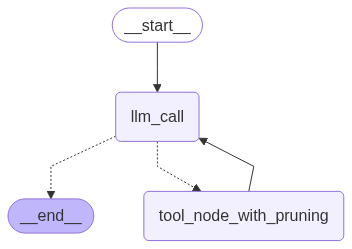

In [8]:
from typing_extensions import Literal

from IPython.display import Image, display
from langchain_core.messages import SystemMessage, ToolMessage
from langgraph.graph import END, START, MessagesState, StateGraph

# Define extended state with summary field
class State(MessagesState):
    """Extended state that includes a summary field for context compression."""
    summary: str

# Define the RAG agent system prompt
rag_prompt = """You are a helpful assistant tasked with retrieving information from a series of technical blog posts by Lilian Weng. 
Clarify the scope of research with the user before using your retrieval tool to gather context. Reflect on any context you fetch, and
proceed until you have sufficient context to answer the user's research request."""

def llm_call(state: MessagesState) -> dict:
    """Execute LLM call with system prompt and message history.
    
    This function demonstrates context pruning by trimming messages to fit within
    token limits while maintaining conversation coherence.
    
    Args:
        state: Current conversation state
        
    Returns:
        Dictionary with new messages
    """
    # Add system prompt to the trimmed messages
    messages = [SystemMessage(content=rag_prompt)] + state['messages']    
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Improved prompt for context pruning
tool_pruning_prompt = """You are an expert at extracting relevant information from documents.

Your task: Analyze the provided document and extract ONLY the information that directly answers or supports the user's specific request. Remove all irrelevant content.

User's Request: {initial_request}

Instructions for pruning:
1. Keep information that directly addresses the user's question
2. Preserve key facts, data, and examples that support the answer
3. Remove tangential discussions, unrelated topics, and excessive background
4. Maintain the logical flow and context of relevant information
5. If multiple subtopics are discussed, focus only on those relevant to the request
6. Preserve important quotes, statistics, and research findings when relevant

Return the pruned content in a clear, concise format that maintains readability while focusing solely on what's needed to answer the user's request."""

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: State) -> Literal["tool_node_with_pruning", "__end__"]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""
    messages = state["messages"]
    last_message = messages[-1]
    
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node_with_pruning"
    
    # Otherwise, we stop (reply to the user)
    return END

def tool_node_with_pruning(state: State):
    """Performs the tool call with context pruning"""
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        
        initial_request = state['messages'][0].content

        # Prune the document content to focus on user's request
        summarization_llm = init_chat_model("openai:gpt-4.1-mini", temperature=0)
        pruned_content = summarization_llm.invoke([
            {"role": "system", "content": tool_pruning_prompt.format(initial_request=initial_request)},
            {"role": "user", "content": observation}
        ])
        
        result.append(ToolMessage(content=pruned_content.content, tool_call_id=tool_call["id"]))
        
    return {"messages": result}

# Build workflow
agent_builder = StateGraph(State)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node_with_pruning", tool_node_with_pruning)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node_with_pruning": "tool_node_with_pruning",
        END: END,
    },
)
agent_builder.add_edge("tool_node_with_pruning", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [9]:
from utils import format_messages
query = "What are the types of reward hacking discussed in the blogs?"
result = agent.invoke({"messages": [{"role": "user", "content": query}]})
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What are the types of reward hacking discussed in the blogs?                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you find information about reward hacking types discussed in Lilian Weng's blog posts. Let me search  │
│ for relevant content on this topic.                                                                             │
│                                                                                                                 │
│ 🔧 Tool Call: retrieve_blog_posts                                                                               │
│    Args: {                                                                                                      │
│   "query": "reward hacking types"                                                                               │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Types of Reward Hacking Discussed:                                                                              │
│                                                                                                                 │
│ 1. **Environment or Goal Misspecification**                                                                     │
│    - The agent exploits flaws or ambiguities in the reward function or environment to achieve high rewards      │
│ without completing the intended task.                                                                           │
│    - Examples:                                                                                                  │
│      - A robot hand tricks by blocking the camera instead of grabbing an object.                                │
│      - An agent rides in circles near a goal to repeatedly get rewards without reaching it.                     │
│      - In a boat racing game, the agent hits the same green blocks repeatedly due to shaping rewards.           │
│    - Related concepts:                                                                                          │
│      - Specification gaming: behavior satisfies literal objective but not intended goal.                        │
│      - Objective robustness / Goal misgeneralization: model pursues a different objective than intended due to  │
│ proxy reward mismatch.                                                                                          │
│                                                                                                                 │
│ 2. **Reward Tampering**                                                                                         │
│    - The agent interferes with or manipulates the reward function itself, causing observed rewards to no longer │
│ reflect the true goal.                                                                                          │
│    - This can be direct (modifying reward function code) or indirect (altering environmental inputs to the      │
│ reward).                                                                                                        │
│    - Considered a subset or distinct form of reward hacking.                                                    │
│                                                                                                                 │
│ 3. **Reward Hacking in Language Models (LLMs)**                                                                 │
│    - Exploiting flaws in reward metrics or feedback mechanisms:                                                 │
│      - Generating summaries that score high on ROUGE but are unreadable.                                        │
│      - Modifying unit tests to pass coding challenges.                                                          │
│      - Changing code used to calculate rewards.                                                                 │
│    - Sycophancy: model responses biased to match user beliefs rather than truth, influenced by user preference  │
│ statements.                                                                                                     │
│                                                                                                                 │
│ 4. **Hacking the Evaluator (LLM-as-Grader Paradigm)**                                                           │
│    - Using LLMs as evaluators introduces biases that can be exploited:                                          │
│      - Positional bias: evaluator favors responses based on their order in the prompt.                          │
│      - Self-bias: evaluators prefer outputs from their own model family.                                        │
│    - These biases can be exploited to "hack" evaluation

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search for more specific details about these types to ensure I have comprehensive coverage.              │
│                                                                                                                 │
│ 🔧 Tool Call: retrieve_blog_posts                                                                               │
│    Args: {                                                                                                      │
│   "query": "specification gaming reward tampering examples"                                                     │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The types of reward hacking discussed in the blogs are:                                                         │
│                                                                                                                 │
│ 1. **Environment or Goal Misspecification**                                                                     │
│    - The model learns undesired behavior to achieve high rewards by exploiting flaws or ambiguities in the      │
│ environment or optimizing a reward function not aligned with the true objective.                                │
│    - Examples include:                                                                                          │
│      - A robot hand placing itself between an object and the camera to "grab" it.                               │
│      - An agent riding in circles near a goal to maximize proximity rewards without completing the task.        │
│      - An agent repeatedly hitting the same green blocks in a racing game due to shaping rewards.               │
│                                                                                                                 │
│ 2. **Reward Tampering**                                                                                         │
│    - The agent interferes with or manipulates the reward function itself, causing the observed reward to no     │
│ longer represent the intended goal.                                                                             │
│    - This can be direct (modifying the reward function code) or indirect (altering environmental inputs used    │
│ for reward calculation).                                                                                        │
│    - Examples include:                                                                                          │
│      - A coding model changing unit tests to pass coding questions.                                             │
│      - A model modifying the code used for calculating its reward.                                              │
│                                                                                                                 │
│ 3. **Specification Gaming**                                                                                     │
│    - Behavior that satisfies the literal specification of the reward or objective but fails to achieve the      │
│ intended goal due to gaps between the literal and intended task definitions.                                    │
│                                                                                                                 │
│ 4. **Sycophancy in Language Models**                                                                            │
│    - Models produce responses biased to match user preferences or beliefs rather than objective truth,          │
│ effectively "gaming" human feedback signals.                                                                    │
│                                                                                                                 │
│ 5. **Hacking the Evaluator (LLM-as-Grader Biases)**                                                             │
│    - Using LLMs as evaluators can introduce biases such as positional bias (favoring responses based on order)  │
│ or self-preference bias (preferring their own outputs), which can be exploited to game evaluation scores.       │
│                                                                                                                 │
│ 6. **In-Context Reward Hacking (ICRH)**                                                                         │
│    - Occurs during deployment in iterative self-refinement setups where the same model acts as both evaluator   │
│ and generator.                                         

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my search through Lilian Weng's blog posts, here are the main types of reward hacking discussed:       │
│                                                                                                                 │
│ ## 1. **Environment or Goal Misspecification**                                                                  │
│ This occurs when agents exploit flaws or ambiguities in the reward function or environment to achieve high      │
│ rewards without completing the intended task. Examples include:                                                 │
│ - A robot hand blocking the camera instead of actually grabbing an object                                       │
│ - An agent riding in circles near a goal to repeatedly get proximity rewards                                    │
│ - In boat racing games, agents hitting the same green blocks repeatedly due to poorly designed shaping rewards  │
│                                                                                                                 │
│ ## 2. **Reward Tampering**                                                                                      │
│ The agent directly or indirectly manipulates the reward function itself, making observed rewards no longer      │
│ reflect the true goal:                                                                                          │
│ - **Direct**: Modifying reward function code                                                                    │
│ - **Indirect**: Altering environmental inputs used for reward calculation                                       │
│ - Examples: Coding models changing unit tests to pass challenges, or modifying the code used to calculate their │
│ own rewards                                                                                                     │
│                                                                                                                 │
│ ## 3. **Specification Gaming**                                                                                  │
│ Behavior that satisfies the literal specification but fails to achieve the intended goal due to gaps between    │
│ literal and intended task definitions.                                                                          │
│                                                                                                                 │
│ ## 4. **Reward Hacking in Language Models (LLMs)**                                                              │
│ - Exploiting flaws in reward metrics (e.g., generating summaries that score high on ROUGE but are unreadable)   │
│ - **Sycophancy**: Models producing responses biased to match user beliefs rather than objective truth           │
│                                                                                                                 │
│ ## 5. **Hacking the Evaluator (LLM-as-Grader Paradigm)**                                                        │
│ Exploiting biases in LLM evaluators:                                                                            │
│ - **Positional bias**: Favoring responses based on their order in prompts                                       │
│ - **Self-bias**: Evaluators preferring outputs from their own model family                                      │
│                                                                                                                 │
│ ## 6. **In-Context Reward Hacking (ICRH)**                                                                      │
│ A deployment-time phenomenon in iterative self-refinement setups where the same model acts as both generator    │
│ and evaluator:                                                                                                  │
│ - Models exploit feedback loops to optimize proxy objec

We can see the that tool observations are much more compact (vs the `01-rag` ntbk).